# $\alpha$-Synuclein Screens

In [1]:
import logging
import os
import textwrap
import time

import gseapy as gp
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from gseapy import gseaplot, gseaplot2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from openpyxl.formatting.rule import ColorScaleRule
from openpyxl.styles import Alignment, Font, PatternFill
from openpyxl.utils import get_column_letter
from openpyxl.worksheet.table import Table, TableStyleInfo

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

_logger = logging.getLogger(__name__)
logging.getLogger("fontTools").setLevel(logging.WARNING)

Read CSVs of nodes and edges.

In [2]:
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, dtype={"edge_index": int, "x_index": int, "y_index": int}, low_memory=False
)
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)
_logger.info(f"Number of nodes: {len(nodes)}")
_logger.info(f"Number of edges: {len(edges) / 2:.0f}")

[12/08/25 22:56:23] INFO     Number of nodes: 147020                                                ]8;id=529083;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3830599195.py\3830599195.py]8;;\:]8;id=392559;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3830599195.py#6\6]8;;\

                    INFO     Number of edges: 7366745                                               ]8;id=889275;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3830599195.py\3830599195.py]8;;\:]8;id=204481;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3830599195.py#7\7]8;;\

## Load KG and Model

Load knowledge graph.

In [3]:
pl.seed_everything(conf.seed, workers=True)
kg = load_graph(nodes, edges)
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# Make output directory
os.makedirs(conf.paths.notebooks.asyn_screens_dir, exist_ok=True)

Seed set to 42


## Conduct *In Silico* Screens

Read full set of protein coding genes downloaded from the [Human Gene Nomenclature Committee](https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_app_name&col=gd_status&col=gd_prev_sym&col=gd_aliases&col=gd_pub_chrom_map&col=gd_pub_acc_ids&col=gd_pub_refseq_ids&col=gd_locus_type&col=gd_locus_group&col=gd_prev_name&col=gd_name_aliases&col=gd_date2app_or_res&col=gd_date_mod&col=gd_date_sym_change&col=gd_date_name_change&col=gd_enz_ids&col=gd_pub_eg_id&col=gd_pub_ensembl_id&col=gd_mgd_id&col=gd_other_ids&col=gd_other_ids_list&col=gd_pubmed_ids&col=family.id&col=family.name&col=gd_ccds_ids&col=gd_vega_ids&col=gd_lsdb_links&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit).

In [4]:
hgnc = pd.read_csv(conf.paths.mappings.hgnc_path, sep="\t", low_memory=False)
protein_coding_genes = hgnc[hgnc["Locus group"] == "protein-coding gene"]

Get PD-association scores for all gene sets.

In [5]:
full_gene_nodes = nodes[nodes["node_type"] == "gene/protein"].copy()
gene_nodes = full_gene_nodes[full_gene_nodes["node_name"].isin(protein_coding_genes["Approved symbol"])]
_logger.info(f"Number of total genes: {len(full_gene_nodes)}")
_logger.info(f"Number of protein-coding genes: {len(gene_nodes)}")

[12/08/25 22:56:37] INFO     Number of total genes: 35198                                           ]8;id=234053;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3490154407.py\3490154407.py]8;;\:]8;id=146316;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3490154407.py#3\3]8;;\

                    INFO     Number of protein-coding genes: 19179                                  ]8;id=571858;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3490154407.py\3490154407.py]8;;\:]8;id=91161;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3490154407.py#4\4]8;;\

In [6]:
full_gene_nodes = nodes[nodes["node_type"] == "gene/protein"].copy()
gene_nodes = full_gene_nodes
preds = gene_nodes.copy()


# Gene-disease association scores
def genetic_association(gene_nodes, disease_id, disease_label, return_time=False):
    gene_nodes = gene_nodes.copy()

    start_time = time.time()
    src_indices = [disease_id] * len(gene_nodes)
    dst_indices = gene_nodes["node_index"].values
    disease_gene_scores = pretrain_model.get_scores_from_embeddings(
        src_indices,
        dst_indices,
        ("disease", "disease_protein", "gene/protein"),
        embeddings=embeddings,
        query_kg=kg,
        use_cache=False,
    )
    end_time = time.time()

    gene_nodes[disease_label + "_score"] = disease_gene_scores.cpu().numpy()
    gene_nodes = gene_nodes.sort_values(disease_label + "_score", ascending=False)
    gene_nodes[disease_label + "_rank"] = np.arange(1, len(gene_nodes) + 1)
    gene_nodes[disease_label + "_per_rank"] = 100 * gene_nodes[disease_label + "_rank"] / len(gene_nodes)

    if not return_time:
        return gene_nodes
    else:
        return gene_nodes, end_time - start_time


# Protein-protein interaction scores
def protein_protein_interaction(gene_nodes, protein_id, protein_label):
    gene_nodes = gene_nodes.copy()
    src_indices = [protein_id] * len(gene_nodes)
    dst_indices = gene_nodes["node_index"].values
    protein_protein_scores = pretrain_model.get_scores_from_embeddings(
        src_indices,
        dst_indices,
        ("gene/protein", "protein_protein", "gene/protein"),
        embeddings=embeddings,
        query_kg=kg,
        use_cache=False,
    )

    gene_nodes[protein_label + "_score"] = protein_protein_scores.cpu().numpy()
    gene_nodes = gene_nodes.sort_values(protein_label + "_score", ascending=False)
    gene_nodes[protein_label + "_rank"] = np.arange(1, len(gene_nodes) + 1)
    gene_nodes[protein_label + "_per_rank"] = 100 * gene_nodes[protein_label + "_rank"] / len(gene_nodes)

    return gene_nodes


# Get IDs for nodes
def get_node_ids(node_name, node_type):
    return nodes[(nodes["node_name"] == node_name) & (nodes["node_type"] == node_type)]["node_index"].values[0]


# Run genetic and protein-protein interaction in silico screens
preds = genetic_association(preds, get_node_ids("Parkinson disease", "disease"), "PD")
preds = protein_protein_interaction(preds, get_node_ids("SNCA", "gene/protein"), "SNCA")

In [7]:
# Create combined score
preds["PD_SNCA_score"] = (preds["PD_score"] + preds["SNCA_score"]) / 2

# Sort by combined score
preds = preds.sort_values("PD_SNCA_score", ascending=False)

# Add combined rank
preds["PD_SNCA_rank"] = np.arange(1, len(preds) + 1)

# Add combined per rank
preds["PD_SNCA_per_rank"] = 100 * preds["PD_SNCA_rank"] / len(preds)

Investigate rankings of certain genes of interest.

In [8]:
COMP_NAME = "PD_SNCA"

# Subset to genes of interest
genes_of_interest_list = [
    "HSPD1",
    "RPS6KA1",
    "RPS6KA3",
    "SRC",
    "MAPK14",
    "FGR",
    "MAPK8",
    "MAPK9",
    "MAPK10",
    "GSK3A",
    "GSK3B",
    "MAPK3",
    "MAPK1",
    "LYN",
    "PLCG1",
]
genes_of_interest = preds[preds["node_name"].isin(genes_of_interest_list)].reset_index(drop=True)
genes_of_interest = genes_of_interest[
    ["node_index", "node_id", "node_name", f"{COMP_NAME}_score", f"{COMP_NAME}_rank", f"{COMP_NAME}_per_rank"]
]
genes_of_interest = genes_of_interest.sort_values(f"{COMP_NAME}_score", ascending=False).reset_index(drop=True)
genes_of_interest["label"] = genes_of_interest.apply(
    lambda row: f"{row['node_name']} (top {row[f'{COMP_NAME}_per_rank']:.2f}%)", axis=1
)
genes_of_interest

,node_index,node_id,node_name,PD_SNCA_score,PD_SNCA_rank,PD_SNCA_per_rank,label
0,418,5594,MAPK1,0.963870,1,0.002841,MAPK1 (top 0.00%)
1,197,1432,MAPK14,0.962062,2,0.005682,MAPK14 (top 0.01%)
2,1169,6714,SRC,0.938600,38,0.107961,SRC (top 0.11%)
3,1331,5335,PLCG1,0.936980,39,0.110802,PLCG1 (top 0.11%)
4,866,5595,MAPK3,0.930578,62,0.176146,MAPK3 (top 0.18%)
5,7649,2268,FGR,0.890392,266,0.755725,FGR (top 0.76%)
6,7170,6197,RPS6KA3,0.887127,293,0.832434,RPS6KA3 (top 0.83%)
7,1454,3329,HSPD1,0.876527,396,1.125064,HSPD1 (top 1.13%)
8,2322,4067,LYN,0.867016,498,1.414853,LYN (top 1.41%)
9,3392,5602,MAPK10,0.858014,584,1.659185,MAPK10 (top 1.66%)


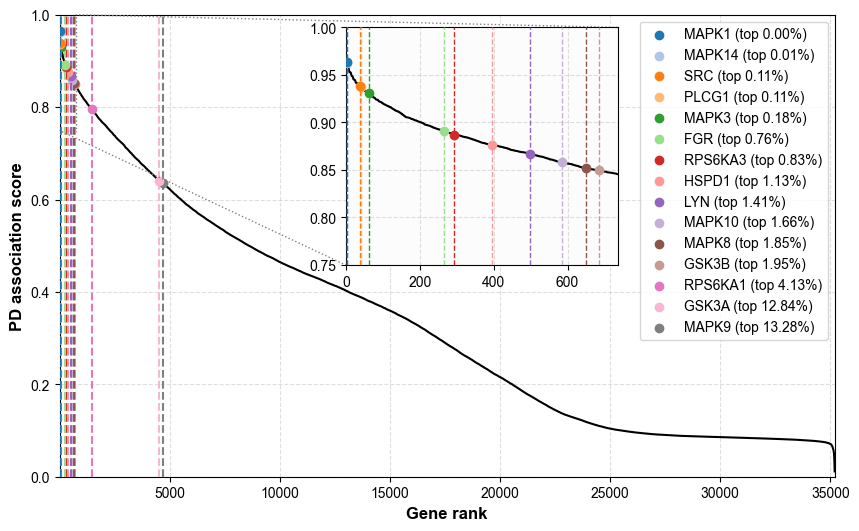

In [9]:
# Sort predictions
display_data = preds.copy().sort_values(f"{COMP_NAME}_rank", ascending=True).reset_index(drop=True)

# Drop SNCA from genes of interest
genes_of_interest = genes_of_interest[genes_of_interest["node_name"] != "SNCA"]
genes_of_interest = genes_of_interest.reset_index(drop=True)

# Plot the main rank vs. score line
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    display_data[f"{COMP_NAME}_rank"].values,
    display_data[f"{COMP_NAME}_score"].values,
    color="black",
    linewidth=1.5,
    zorder=2,
)
ax.set_xlabel("Gene rank", fontsize=12, fontweight="bold")
ax.set_ylabel("PD association score", fontsize=12, fontweight="bold")
ax.set_xlim(1, display_data[f"{COMP_NAME}_rank"].max())
ax.set_ylim(0, max(display_data[f"{COMP_NAME}_score"].max(), 1))

# Generate palette with distinct categorical colors
palette = sns.color_palette("tab20", len(genes_of_interest))

# For each gene of interest, draw a vertical line at the gene's rank
k = 100
for i, node in genes_of_interest.iterrows():
    ax.scatter(node[f"{COMP_NAME}_rank"], node[f"{COMP_NAME}_score"], color=palette[i], label=node["label"], zorder=k)
    ax.axvline(x=node[f"{COMP_NAME}_rank"], color=palette[i], linestyle="--", linewidth=1.5, zorder=k)
    k = k - 1

genes_of_interest_sub = genes_of_interest[genes_of_interest[f"{COMP_NAME}_per_rank"] < 4]

# Create inset zoom box
zoom_factor = 1
axins = inset_axes(
    ax,
    width="70%",
    height="50%",
    loc="right",
    bbox_to_anchor=(0.22, 0.2, 0.5, 1.03),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

axins.plot(
    display_data[f"{COMP_NAME}_rank"].values,
    display_data[f"{COMP_NAME}_score"].values,
    color="black",
    linewidth=1.5,
    zorder=2,
)
k = 100
for i, node in genes_of_interest_sub.iterrows():
    axins.scatter(node[f"{COMP_NAME}_rank"], node[f"{COMP_NAME}_score"], color=palette[i], zorder=k)
    axins.axvline(x=node[f"{COMP_NAME}_rank"], color=palette[i], linestyle="--", linewidth=1, zorder=k)
    k = k - 1

# Establish limits for the inset
x_min = max(genes_of_interest_sub[f"{COMP_NAME}_rank"].min() - 100, 0)
x_max = genes_of_interest_sub[f"{COMP_NAME}_rank"].max() + 50
y_min = genes_of_interest_sub[f"{COMP_NAME}_score"].min() - 0.1
y_max = min(genes_of_interest_sub[f"{COMP_NAME}_score"].max() + 0.045, 1)

axins.set_xlim(x_min, x_max)
axins.set_ylim(y_min, y_max)
axins.set_facecolor("#FCFCFD")
mark_inset(ax, axins, loc1=1, loc2=3, fc="#FCFCFD", ec="0.5", linewidth=1, linestyle=":")

ax.legend(loc="upper right", fontsize=10)
ax.grid(linestyle="--", alpha=0.4, zorder=0)
axins.grid(linestyle="--", alpha=0.4, zorder=0)

# Save figure
os.makedirs(conf.paths.notebooks.asyn_screens_dir, exist_ok=True)
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "genes_of_interest.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "genes_of_interest.svg", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "genes_of_interest.png", dpi=600, bbox_inches="tight")

plt.show()

# Compare with Experimental Screens

Get gene/protein neighbors of PD.

In [10]:
PD_genes = edges[(edges["x_index"] == 39579) & (edges["y_type"] == "gene/protein")]
PD_genes = PD_genes["y_name"].unique().tolist()

Read in results of experimental $\alpha$-synuclein screens.

In [11]:
asyn_screens = pd.ExcelFile(conf.paths.notebooks.asyn_screens)

# Load the gene lists
asyn_screens = {
    "TES_hits": pd.read_excel(asyn_screens, sheet_name="TES hits - synucleinopathy"),
    "APX_hits": pd.read_excel(asyn_screens, sheet_name="Spatial interactome "),
    "asyn_genetic_modifiers": pd.read_excel(asyn_screens, sheet_name="aSyn full genetic modifiers"),
    "cross_proteinopathy": pd.read_excel(asyn_screens, sheet_name="Cross proteinopathy OE screens"),
}

asyn_screens["TES_hits"].columns = ["gene"]
asyn_screens["APX_hits"].columns = ["APX", "MYTH", "SILAC"]
asyn_screens["asyn_genetic_modifiers"].columns = ["gene"]
asyn_screens["cross_proteinopathy"].columns = ["ABETA", "ASYN", "TDP43"]

gene_sets = {
    "aSyn TES screen": list(asyn_screens["TES_hits"]["gene"].dropna().values),
    "APX aSyn interactome": list(asyn_screens["APX_hits"]["APX"].dropna().values),
    "MYTH aSyn interactome": list(asyn_screens["APX_hits"]["MYTH"].dropna().values),
    "SILAC aSyn interactome": list(asyn_screens["APX_hits"]["SILAC"].dropna().values),
    "aSyn genetic modifiers": list(asyn_screens["asyn_genetic_modifiers"]["gene"].dropna().values),
    "aSyn overexpression": list(asyn_screens["cross_proteinopathy"]["ASYN"].dropna().values),
    # Random background
    "Random genes": preds[~preds["node_name"].isin(PD_genes)]["node_name"].sample(n=500, random_state=42).values,
}

### Exclude Known Interactors

To prevent information leakage, exclude gene or protein nodes with a link to the PD node or to the $\alpha$-synuclein nodes in NeuroKG from the analysis. 

In [12]:
# Drop PD genes from gene sets
gene_sets_unknown = {k: [g for g in v if g not in PD_genes] for k, v in gene_sets.items()}

# Print difference between gene sets
for k in gene_sets_unknown:
    original_len = len(gene_sets[k])
    unknown_len = len(gene_sets_unknown[k])
    difference = original_len - unknown_len
    print(f"{k}: original: {original_len}, unknown: {unknown_len}, difference: {difference}")

    if difference < 25 and difference > 0:
        # Print removed genes
        removed_genes = set(gene_sets[k]) - set(gene_sets_unknown[k])
        print(f"Removed genes: {removed_genes}")

aSyn TES screen: original: 27, unknown: 23, difference: 4
Removed genes: {'LRRK2', 'PTPRS', 'PTPN18', 'CD33'}
APX aSyn interactome: original: 225, unknown: 200, difference: 25
MYTH aSyn interactome: original: 260, unknown: 239, difference: 21
Removed genes: {'MAP4K2', 'MAPT', 'VPS28', 'HFE', 'B4GALT1', 'RET', 'CSNK2A2', 'RAB26', 'NECAP2', 'SNCA', 'HSPA1B', 'CLSTN2', 'SCYL1', 'ANXA2', 'RAB20', 'HSPA1A', 'FOLR3', 'TGM2', 'BCL6', 'CHRM3', 'AP2M1'}
SILAC aSyn interactome: original: 50, unknown: 47, difference: 3
Removed genes: {'SV2C', 'ZC3H15', 'BRD8'}
aSyn genetic modifiers: original: 437, unknown: 394, difference: 43
aSyn overexpression: original: 245, unknown: 218, difference: 27
Random genes: original: 500, unknown: 500, difference: 0


In [13]:
# For each gene list, test how many genes are in KG
gene_list_length = {}

for list_name, gene_list in gene_sets_unknown.items():
    original_len = len(set(gene_sets[list_name]))
    unique_len = len(set(gene_list))
    in_KG = len(set(gene_list) & set(preds["node_name"].values))
    percent_in_KG = in_KG / unique_len * 100
    gene_list_length[list_name] = (original_len, unique_len, in_KG, percent_in_KG)

gene_list_length_df = pd.DataFrame(gene_list_length)
gene_list_length_df = gene_list_length_df.T
gene_list_length_df.columns = ["Original length", "Unknown length", "In KG", "Percent unknown in KG"]
gene_list_length_df = gene_list_length_df.astype({
    "Original length": "int",
    "Unknown length": "int",
    "In KG": "int",
    "Percent unknown in KG": "float",
})

gene_list_length_df

,Original length,Unknown length,In KG,Percent unknown in KG
aSyn TES screen,27,23,21,91.304348
APX aSyn interactome,212,187,175,93.582888
MYTH aSyn interactome,260,239,228,95.397490
SILAC aSyn interactome,50,47,42,89.361702
aSyn genetic modifiers,437,394,370,93.908629
aSyn overexpression,245,218,218,100.000000
Random genes,500,500,500,100.000000


Run GSEAs for different comparisons.

In [14]:
gsea_comparison = {}

for COMP_NAME in ["PD", "SNCA", "PD_SNCA"]:
    # Set seed
    np.random.seed(conf.seed)
    _logger.info(f"In silico screen: {COMP_NAME}")

    # Subset to protein-coding genes
    rnk = preds[["node_name", f"{COMP_NAME}_score"]]
    rnk = rnk[rnk["node_name"].isin(protein_coding_genes["Approved symbol"])]

    # Drop PD genes from rnk
    rnk = rnk[~rnk["node_name"].isin(PD_genes)]

    pre_res = gp.prerank(
        # rnk=rnk, gene_sets=gene_sets,
        rnk=rnk,
        gene_sets=gene_sets_unknown,
        threads=4,
        min_size=1,
        max_size=2000,
        verbose=True,
        seed=conf.seed
    )

    # Save GSEA results to CSV
    os.makedirs(conf.paths.notebooks.asyn_screens_dir / COMP_NAME, exist_ok=True)
    gsea_results = pre_res.res2d
    gsea_results.to_csv(
        conf.paths.notebooks.asyn_screens_dir / COMP_NAME / f"{COMP_NAME}_gsea_results.csv", index=False
    )

    # Append to GSEA comparison
    gsea_comparison[COMP_NAME] = gsea_results
    display(gsea_results)

[12/08/25 22:56:39] INFO     In silico screen: PD                                                   ]8;id=243962;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3057191224.py\3057191224.py]8;;\:]8;id=529903;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3057191224.py#6\6]8;;\

2025-12-08 22:56:39,814 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-08 22:56:39,814 [INFO] Parsing data files for GSEA.............................
2025-12-08 22:56:39,827 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=1
2025-12-08 22:56:39,828 [INFO] 0007 gene_sets used for further statistical testing.....
2025-12-08 22:56:39,828 [INFO] Start to run GSEA...Might take a while..................
2025-12-08 22:56:40,343 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,MYTH aSyn interactome,0.417818,1.721364,0.0,0.005018,0.005,125/228,29.98%,FGFR4;FBXW7;KDR;CAV1;MDM2;RAC1;RHOA;PLAT;PRKAR...
1,prerank,aSyn TES screen,0.522695,1.664859,0.004094,0.003011,0.006,13/21,25.64%,PRKCD;PTPRB;PSEN2;CR1;SEC31A;MAP2K3;XRN1;ATP2A...
2,prerank,APX aSyn interactome,0.396342,1.603299,0.0,0.003345,0.01,102/175,35.61%,SMAD2;CTNNB1;CBL;HSP90AA1;PLCG1;RAC1;NDRG1;MIF...
3,prerank,aSyn genetic modifiers,0.352707,1.482725,0.0,0.013047,0.051,199/369,37.93%,MAPK1;FBXW7;HDAC6;HSP90AA1;AKT2;PRL;FHIT;CTLA4...
4,prerank,aSyn overexpression,0.316065,1.305841,0.006,0.045763,0.211,113/216,39.66%,NOTCH1;FBXW7;AKT2;ROCK1;HLA-DRB1;RAF1;PTPRC;CR...
5,prerank,SILAC aSyn interactome,0.290796,1.04309,0.441884,0.436057,0.958,23/42,44.32%,ALDOA;PDHB;KIF5B;PRKACG;RAD51;MTHFD2;MAT2A;SLC...
6,prerank,Random genes,0.240266,1.001244,0.497,0.49491,0.986,126/266,45.94%,TET2;POU2F2;OTOF;TRAPPC4;LHB;CYP2B6;PIK3CD;TBX...


[12/08/25 22:56:40] INFO     In silico screen: SNCA                                                 ]8;id=750800;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3057191224.py\3057191224.py]8;;\:]8;id=681453;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3057191224.py#6\6]8;;\

2025-12-08 22:56:40,362 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-08 22:56:40,366 [INFO] Parsing data files for GSEA.............................
2025-12-08 22:56:40,413 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=1
2025-12-08 22:56:40,414 [INFO] 0007 gene_sets used for further statistical testing.....
2025-12-08 22:56:40,415 [INFO] Start to run GSEA...Might take a while..................
2025-12-08 22:56:40,949 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,MYTH aSyn interactome,0.372614,2.094049,0.0,0.00101,0.001,150/228,37.90%,FGFR4;FBXW7;VCP;CDC42;CAV1;PTPN6;GAB2;CSNK1D;E...
1,prerank,aSyn TES screen,0.530006,2.053429,0.0,0.000505,0.001,12/21,16.28%,PRKCD;PSEN2;MICAL3;ATP2A1;ARHGEF1;PTPRB;TEAD2;...
2,prerank,APX aSyn interactome,0.368668,2.016964,0.0,0.000337,0.001,128/175,44.34%,YWHAH;SMAD2;HSP90AA1;ACTN1;PLCG1;VCP;ABI2;DNM1...
3,prerank,aSyn overexpression,0.28395,1.580477,0.0,0.007575,0.03,128/216,42.21%,ROCK1;PRKCB;FBXW7;CSNK1D;NOTCH1;EGR1;PLK2;ATP2...
4,prerank,aSyn genetic modifiers,0.272312,1.570013,0.0,0.00606,0.03,210/369,40.76%,MAPK1;HSP90AA1;FBXW7;PTPN6;CALM1;CDH2;VDAC1;PR...
5,prerank,SILAC aSyn interactome,0.305177,1.392817,0.062374,0.027269,0.156,36/42,59.78%,PRKACG;GIT1;VAPA;PDHB;SLC27A4;VAPB;ALDOA;MAT2A...
6,prerank,Random genes,0.180694,1.030134,0.411,0.413216,0.965,156/266,56.03%,TFAP2A;POU2F2;RPS6KA3;PDLIM7;SPTAN1;PIN1;OTOF;...


                    INFO     In silico screen: PD_SNCA                                              ]8;id=471029;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3057191224.py\3057191224.py]8;;\:]8;id=617889;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/3057191224.py#6\6]8;;\

2025-12-08 22:56:40,966 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-08 22:56:40,966 [INFO] Parsing data files for GSEA.............................
2025-12-08 22:56:40,978 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=1
2025-12-08 22:56:40,978 [INFO] 0007 gene_sets used for further statistical testing.....
2025-12-08 22:56:40,979 [INFO] Start to run GSEA...Might take a while..................
2025-12-08 22:56:41,445 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,MYTH aSyn interactome,0.421983,2.302613,0.0,0.0,0.0,142/228,31.97%,FGFR4;FBXW7;CAV1;RAC1;VCP;PRKAR1A;MDM2;CDC42;R...
1,prerank,APX aSyn interactome,0.410197,2.156262,0.0,0.0,0.0,107/175,32.26%,SMAD2;HSP90AA1;PLCG1;ACTN1;RAC1;VCP;CBL;CTNNB1...
2,prerank,aSyn TES screen,0.561597,2.128928,0.0,0.0,0.0,13/21,19.75%,PRKCD;PSEN2;PTPRB;MICAL3;SEC31A;ATP2A1;CR1;TEA...
3,prerank,aSyn genetic modifiers,0.315405,1.760364,0.0,0.001514,0.006,190/369,34.07%,MAPK1;HSP90AA1;FBXW7;HDAC6;PRL;CALM1;IRS2;VDAC...
4,prerank,aSyn overexpression,0.299569,1.612011,0.0,0.005452,0.027,126/216,41.65%,NOTCH1;FBXW7;ROCK1;RAF1;ATP2A2;AKT2;PRKCB;CREB...
5,prerank,SILAC aSyn interactome,0.296254,1.289806,0.123984,0.070003,0.35,29/42,49.37%,PRKACG;PDHB;ALDOA;KIF5B;GIT1;SLC27A4;RAD51;MAT...
6,prerank,Random genes,0.176999,0.963624,0.593,0.578249,0.994,139/266,50.84%,POU2F2;TET2;RPS6KA3;OTOF;TFAP2A;TRAPPC4;FYB1;E...


Visualize results of the combined genetic-PPI screen using running score visualizations.

In [15]:
# Define color palette
cmap = mpl.colormaps["Set1"].resampled(9)
custom_colors = [cmap(i) for i in range(9)]
custom_colors = custom_colors[:5] + custom_colors[6:]
custom_colors[5], custom_colors[6] = custom_colors[6], custom_colors[5]
custom_colors.pop(-2)
custom_colors = custom_colors[::-1]

In [16]:
terms = list(pre_res.res2d.Term.values)
terms = terms[::-1]

# Plot each term
for i, _term in enumerate(terms):
    gseaplot(
        rank_metric=pre_res.ranking,
        term=terms[i],
        **pre_res.results[terms[i]],
        figsize=(8, 6),
    )

    # Save plot
    plt.savefig(conf.paths.notebooks.asyn_screens_dir / COMP_NAME / f"{terms[i]}.pdf", bbox_inches="tight")
    plt.savefig(conf.paths.notebooks.asyn_screens_dir / COMP_NAME / f"{terms[i]}.svg", bbox_inches="tight")
    # plt.savefig(conf.paths.notebooks.asyn_screens_dir / COMP_NAME / f"{terms[i]}.png", dpi=600, bbox_inches="tight")

    # Clear plot
    plt.close()

In [17]:
hits = [pre_res.results[t]["hits"] for t in terms]
runes = [pre_res.results[t]["RES"] for t in terms]
terms_to_plot = [x.replace("aSyn", "$\\alpha$Syn") for x in terms]

fig = gseaplot2(
    terms=terms_to_plot,
    RESs=runes,
    hits=hits,
    rank_metric=pre_res.ranking,
    legend_kws={"loc": "upper right", "bbox_to_anchor": (1, 1), "ncol": 1},
    colors=custom_colors,
    figsize=(10, 12),
)

# Save plot
plt.savefig(conf.paths.notebooks.asyn_screens_dir / COMP_NAME / "combined_GSEA.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.asyn_screens_dir / COMP_NAME / "combined_GSEA.svg", bbox_inches="tight")
# plt.savefig(conf.paths.notebooks.asyn_screens_dir / COMP_NAME / "combined_GSEA.png", dpi=600, bbox_inches="tight")
plt.close()

Save GSEA results to CSV.

In [18]:
# Convert RGBA to hex
def rgba_to_hex(rgba):
    r, g, b, _ = rgba
    return mcolors.to_hex((r, g, b)).replace("#", "").upper()


# Save results
TOP_K = 10000
comp_results = preds[
    ["node_index", "node_id", "node_name", f"{COMP_NAME}_score", f"{COMP_NAME}_rank", f"{COMP_NAME}_per_rank"]
].copy()

# Order gene sets by terms
comp_gene_sets = {term: gene_sets_unknown[term] for term in terms[::-1]}
comp_colors = custom_colors[::-1]
comp_colors = [rgba_to_hex(c) for c in comp_colors]
assert len(comp_gene_sets) == len(comp_colors), "Mismatch between gene sets and colors"

# Add columns for each gene set
for name, genes in comp_gene_sets.items():
    comp_results[name] = comp_results["node_name"].isin(genes).map({True: "×", False: ""})

comp_results = comp_results.head(TOP_K).reset_index(drop=True)
comp_results = comp_results.rename(
    columns={
        "node_index": "Index",
        "node_id": "ID",
        "node_name": "Name",
        f"{COMP_NAME}_score": "Score",
        f"{COMP_NAME}_rank": "Rank",
        f"{COMP_NAME}_per_rank": "% Rank",
    }
)

# Save to Excel
excel_path = conf.paths.notebooks.asyn_screens_dir / COMP_NAME / f"{COMP_NAME}_top{TOP_K}_results.xlsx"
if preds.shape[0] == TOP_K:
    excel_path = conf.paths.notebooks.asyn_screens_dir / COMP_NAME / f"{COMP_NAME}_full_results.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    comp_results.to_excel(writer, sheet_name="Results", index=False)

    wb = writer.book
    ws = writer.sheets["Results"]

    # Global Arial font
    arial_font = Font(name="Arial")
    for row in ws.iter_rows():
        for cell in row:
            cell.font = arial_font

    # Header styling
    header_fill = PatternFill(start_color="363635", end_color="363635", fill_type="solid")
    header_font = Font(name="Arial", bold=True, color="FFFFFF")

    for col_idx, _ in enumerate(comp_results.columns, 1):
        cell = ws.cell(row=1, column=col_idx)
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal="center")

    # Freeze header
    ws.freeze_panes = "A2"

    # Autofit columns
    for i, col in enumerate(comp_results.columns, 1):
        max_len = max(comp_results[col].astype(str).map(len).max(), len(col))
        ws.column_dimensions[get_column_letter(i)].width = max_len + 2

    # For each gene set, set width to 20
    for col in comp_gene_sets:
        ws.column_dimensions[get_column_letter(comp_results.columns.get_loc(col) + 1)].width = 22

    # Color‑scale for score & percentile columns
    numeric_cols = ["Score"]
    for col in numeric_cols:
        if col in comp_results.columns:
            idx = comp_results.columns.get_loc(col) + 1
            cell_range = f"{get_column_letter(idx)}2:{get_column_letter(idx)}{len(comp_results) + 1}"
            cs_rule = ColorScaleRule(
                start_type="min",
                start_color="FFF8696B",
                mid_type="percentile",
                mid_value=50,
                mid_color="FFFFEB84",
                end_type="max",
                end_color="FF63BE7B",
            )
            ws.conditional_formatting.add(cell_range, cs_rule)

    # Enable filters
    # ws.auto_filter.ref = ws.dimensions

    # Style gene set columns with unique "Set1" colors
    x_font = Font(name="Arial", bold=True, color="FFFFFF")
    x_alignment = Alignment(horizontal="center")

    # Assign colors to gene set columns
    for color_idx, col in enumerate(comp_gene_sets):
        hex_color = comp_colors[color_idx % len(comp_colors)]
        fill = PatternFill(start_color=hex_color, end_color=hex_color, fill_type="solid")
        col_idx = comp_results.columns.get_loc(col) + 1

        for row_idx in range(2, len(comp_results) + 2):  # Skip header
            cell = ws.cell(row=row_idx, column=col_idx)
            if cell.value == "×":
                cell.fill = fill
                cell.font = x_font
                cell.alignment = x_alignment

    last_col_letter = get_column_letter(ws.max_column)
    last_row = ws.max_row
    table_range = f"A1:{last_col_letter}{last_row}"

    table = Table(displayName="GeneSetEnrichment", ref=table_range)
    style = TableStyleInfo(name="TableStyleLight1", showRowStripes=True)
    table.tableStyleInfo = style
    ws.add_table(table)

## Random Walk Baseline

Compare PROTON performance to random walk with restart (RWR), a network science method. See `src/baselines/random_walk_simulator.py` for implementation.

In [19]:
# Read random walk visit count
random_walk_df = pd.read_parquet(conf.paths.notebooks.asyn_screens_dir / "PD_random_walk_node_visit_count.parquet")
random_walk_df = random_walk_df.rename(
    columns={
        "id": "node_index",
        "external_id": "node_id",
        "type": "node_type",
        "name": "node_name",
        "source": "node_source",
    }
)

# Filter for genes
random_walk_df = random_walk_df[random_walk_df["node_type"] == "gene/protein"]

# Set seed
np.random.seed(conf.seed)

# Create a random variable from 1 to 10000
random_walk_df["random"] = np.random.randint(1, 10000, size=len(random_walk_df))

# Sort by visit count then by random
random_walk_df = random_walk_df.sort_values(["visit_count", "random"], ascending=[False, True]).reset_index(drop=True)

# Add rank and percentage rank columns
random_walk_df["PD_rank"] = range(1, len(random_walk_df) + 1)
random_walk_df["PD_per_rank"] = 100 * random_walk_df["PD_rank"] / len(random_walk_df)

In [20]:
np.random.seed(conf.seed)

# Subset to protein-coding genes
rw_rnk = random_walk_df[["node_name", "visit_count"]]
rw_rnk = rw_rnk[rw_rnk["node_name"].isin(protein_coding_genes["Approved symbol"])]

rw_pre_res = gp.prerank(rnk=rw_rnk, gene_sets=gene_sets, threads=4, min_size=1, max_size=2000, verbose=True, seed=conf.seed)

# Make directory for random walk results
rw_gsea_results = rw_pre_res.res2d
os.makedirs(conf.paths.notebooks.asyn_screens_dir / "random_walk", exist_ok=True)
rw_gsea_results.to_csv(conf.paths.notebooks.asyn_screens_dir / "random_walk" / "rw_gsea_results.csv", index=False)

# Append to GSEA comparison
gsea_comparison["random_walk"] = rw_gsea_results
rw_gsea_results

2025-12-08 22:56:47,184 [WARNING] Duplicated values found in preranked stats: 99.85% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-08 22:56:47,184 [INFO] Parsing data files for GSEA.............................
2025-12-08 22:56:47,199 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=1
2025-12-08 22:56:47,200 [INFO] 0007 gene_sets used for further statistical testing.....
2025-12-08 22:56:47,200 [INFO] Start to run GSEA...Might take a while..................
2025-12-08 22:56:47,982 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,APX aSyn interactome,0.598457,1.36982,0.0,0.027,0.027,89/200,20.48%,COPB1;SNCA;PPP1CB;GDI1;XPO1;MAPT;CLTC;PPP2R1A;...
1,prerank,aSyn TES screen,0.651019,1.339156,0.032,0.0205,0.041,11/25,15.49%,PTPRS;LRRK2;CD33;PTPN18;PRKCD;PTPRR;ATP2A3;SH3...
2,prerank,MYTH aSyn interactome,0.573106,1.31963,0.0,0.016,0.048,119/249,23.91%,SNCA;MAPT;CHRM3;NECAP2;EGR1;RAB20;HSPA1B;ANXA2...
3,prerank,aSyn overexpression,0.537255,1.235932,0.001,0.03775,0.146,100/243,24.95%,SOD1;SNCA;SOD2;AKT1;RELA;HLA-DRB5;PPP2R1A;EGR1...
4,prerank,aSyn genetic modifiers,0.525777,1.221729,0.0,0.0374,0.18,172/411,26.73%,HMOX1;SNCA;PPP1CB;CADPS2;ING3;DNAJB6;LRRK2;PTP...
5,prerank,SILAC aSyn interactome,0.461532,0.9891,0.514,0.635,0.996,26/45,43.60%,ZC3H15;BRD8;SV2C;SFPQ;PRKACG;CEP120;FEN1;PDHB;...
6,prerank,Random genes,0.371895,0.85677,0.99,0.938714,1.0,128/266,48.36%,RGS6;ERH;NUDCD2;PIN1;TET2;ZNF273;RPL17;TFAP2A;...


Plot results of GSEA with the graph walk baseline.

In [21]:
# Get terms
rw_terms = rw_pre_res.res2d.Term

# Plot each term
for i, _term in enumerate(rw_terms):
    gseaplot(
        rank_metric=rw_pre_res.ranking,
        term=rw_terms[i],
        **rw_pre_res.results[terms[i]],
        figsize=(8, 6),
    )

    # Save plot
    plt.savefig(conf.paths.notebooks.asyn_screens_dir / "random_walk" / f"rw_{rw_terms[i]}.pdf", bbox_inches="tight")
    plt.savefig(conf.paths.notebooks.asyn_screens_dir / "random_walk" / f"rw_{rw_terms[i]}.svg", bbox_inches="tight")
    plt.savefig(
        conf.paths.notebooks.asyn_screens_dir / "random_walk" / f"rw_{rw_terms[i]}.png",
        dpi=600,
        bbox_inches="tight",
    )

    # Clear plot
    plt.close()

In [22]:
# Note we use "terms" here, not "rw_terms"
# For consistency with the other GSEA plots
hits = [rw_pre_res.results[t]["hits"] for t in terms]
runes = [rw_pre_res.results[t]["RES"] for t in terms]
fig = gseaplot2(
    terms=terms,
    RESs=runes,
    hits=hits,
    rank_metric=rw_pre_res.ranking,
    legend_kws={"loc": "upper right", "bbox_to_anchor": (1, 1), "ncol": 1},  # set the legend loc
    colors=custom_colors,
    figsize=(10, 12),
)

# Save plot
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "random_walk" / "rw_combined_GSEA.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "random_walk" / "rw_combined_GSEA.svg", bbox_inches="tight")
plt.savefig(
    conf.paths.notebooks.asyn_screens_dir / "random_walk" / "rw_combined_GSEA.png", dpi=600, bbox_inches="tight"
)
plt.close()

## Compare Enrichment Results

In [23]:
# Combine and order data frames
combined_list = []
for analysis_name, df in gsea_comparison.items():
    temp_df = df.copy()
    temp_df["analysis"] = analysis_name
    combined_list.append(temp_df)

combined_df = pd.concat(combined_list, ignore_index=True)
combined_df["analysis"] = combined_df["analysis"].replace({
    "SNCA": "$\\alpha$-synuclein",
    "PD_SNCA": "PD + $\\alpha$-synuclein",
    "random_walk": "RWR",
})

plot_df = combined_df.pivot_table(index="Term", columns="analysis", values="NES")
qval_df = combined_df.pivot_table(index="Term", columns="analysis", values="FDR q-val")

plot_df = plot_df[["PD + $\\alpha$-synuclein", "$\\alpha$-synuclein", "PD", "RWR"]]

# Order rows by `terms`
plot_df = plot_df.reindex(terms[::-1])

In [24]:
# Update groups and display names
SP1, SP2 = "sp1", "sp2"
desired_order = [
    "MYTH aSyn interactome",
    "APX aSyn interactome",
    "SILAC aSyn interactome",
    SP1,
    "aSyn TES screen",
    "aSyn genetic modifiers",
    "aSyn overexpression",
    SP2,
    "Random genes",
]

plot_df = plot_df.reindex(desired_order)
qval_df = qval_df.reindex(desired_order)

display_map = {
    "MYTH aSyn interactome": "MYTH interactome",
    "APX aSyn interactome": "APEX2 proximity labeling",
    "SILAC aSyn interactome": "SILAC mass spectrometry",
    "aSyn TES screen": "Targeted exome sequencing",
    "aSyn genetic modifiers": "Proteotoxicity modifiers",
    "aSyn overexpression": "Modifier yeast overexpression",
    "Random genes": "Random genes",
    SP1: "",
    SP2: "",
}

In [25]:
# Find smallest p-value
p_vals = combined_df["FDR q-val"].values
min_nonzero = min([x for x in p_vals if x != 0])
_logger.info(f"Smallest non-zero p-value: {min_nonzero:.2e}")

[12/08/25 22:56:54] INFO     Smallest non-zero p-value: 3.37e-04                                    ]8;id=167414;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/2873067209.py\2873067209.py]8;;\:]8;id=732052;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_79972/2873067209.py#4\4]8;;\

In [26]:
# Helper to wrap text labels
def wrap_with_dash(label, width=12):
    parts = textwrap.wrap(label, width=width, break_long_words=False)
    return "\n".join(parts)


# Build wrapped labels for every tick
tick_labels = [display_map.get(lbl, lbl) for lbl in plot_df.index]
wrapped_labels = [wrap_with_dash(lbl, width=15) if lbl else "" for lbl in tick_labels]

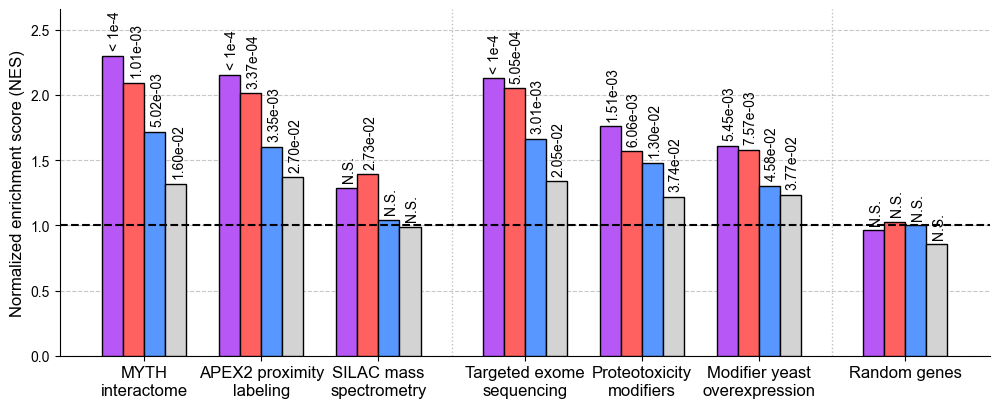

In [27]:
fig, ax = plt.subplots(figsize=(12, 4.5))

SPACERS = (SP1, SP2)
n_series = len(plot_df.columns)

# Build custom x positions
step_norm = 1.0
step_space = 0.25
xpos = []
x = 0.0
for t in plot_df.index:
    xpos.append(x)
    x += step_space if t in SPACERS else step_norm
xpos = np.array(xpos)

# Draw grouped bars manually
bar_w = 0.18
intra_gap = 1
offsets = (np.arange(n_series) - (n_series - 1) / 2) * (bar_w * intra_gap)

bars_by_col = []
terms_by_col = []

for j, col in enumerate(plot_df.columns):
    xs, ys, ts = [], [], []
    col_vals = plot_df[col].values
    for i, t in enumerate(plot_df.index):
        y = col_vals[i]
        if (t in SPACERS) or (pd.isna(y)):
            continue
        xs.append(xpos[i] + offsets[j])
        ys.append(y)
        ts.append(t)
    bars = ax.bar(
        xs,
        ys,
        width=bar_w,
        edgecolor="black",
        linewidth=1,
        zorder=3,
        label=col,
        color=["#B757F6", "#FF6060", "#5797FF", "lightgray"][j],
    )
    bars_by_col.append(bars)
    terms_by_col.append(ts)

# Tick labels
ax.set_xticks(xpos)
ax.set_xticklabels(wrapped_labels, rotation=0, ha="center")

# Horizontal line and grid
ax.axhline(y=1, color="black", linewidth=1.5, linestyle="--", zorder=5, label="Random")
ax.grid(axis="y", linestyle="--", alpha=0.7, zorder=0)
ax.set_ylabel("Normalized enrichment score (NES)", fontsize=12)
ax.set_xlabel("")
plt.xticks(fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Annotations
for bars, col_name, term_list in zip(bars_by_col, plot_df.columns, terms_by_col, strict=False):
    for bar, term_name in zip(bars, term_list, strict=False):
        height = bar.get_height()
        q_val = qval_df.loc[term_name, col_name]
        if pd.isna(q_val):
            continue
        q_text = f"{q_val:.2e}" if q_val < 0.05 else "N.S."
        if q_val == 0:
            q_text = "< 1e-4"
        ax.text(
            bar.get_x() + bar.get_width() / 2 + 0.02,
            height + 0.04,
            q_text,
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=10,
            zorder=7,
        )

# Expand y-limit
_, ymax = ax.get_ylim()
ax.set_ylim(top=ymax * 1.1)

for i, term in enumerate(plot_df.index):
    if term in (SP1, SP2) and 0 < i < len(xpos) - 1:
        left_center = xpos[i - 1]
        right_center = xpos[i + 1]
        mid = 0.5 * (left_center + right_center)
        ax.axvline(x=mid, linestyle=":", linewidth=1, color="k", alpha=0.25, zorder=1)

for i, lbl in enumerate(ax.get_xticklabels()):
    if plot_df.index[i] in SPACERS:
        ax.get_xticklines()[2 * i].set_visible(False)
        ax.get_xticklines()[2 * i + 1].set_visible(False)

# Save figure
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "asyn_gsea_comparison.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "asyn_gsea_comparison.svg", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.asyn_screens_dir / "asyn_gsea_comparison.png", dpi=600, bbox_inches="tight")
plt.show()

In [28]:
# Compute fold change between combined and graph walk baseline
fc_df = plot_df.copy()
fc_df = fc_df.dropna(subset=["PD + $\\alpha$-synuclein", "RWR"])
fc_df["fold_change"] = fc_df["PD + $\\alpha$-synuclein"] / fc_df["RWR"]
fc_df["percent_change"] = (fc_df["fold_change"] - 1) * 100
fc_df

analysis,PD + $\alpha$-synuclein,$\alpha$-synuclein,PD,RWR,fold_change,percent_change
Term,,,,,,
MYTH aSyn interactome,2.302613,2.094049,1.721364,1.31963,1.744892,74.489212
APX aSyn interactome,2.156262,2.016964,1.603299,1.36982,1.57412,57.412044
SILAC aSyn interactome,1.289806,1.392817,1.04309,0.9891,1.304019,30.401947
aSyn TES screen,2.128928,2.053429,1.664859,1.339156,1.589753,58.975309
aSyn genetic modifiers,1.760364,1.570013,1.482725,1.221729,1.44088,44.087992
aSyn overexpression,1.612011,1.580477,1.305841,1.235932,1.304288,30.428792
Random genes,0.963624,1.030134,1.001244,0.85677,1.124717,12.471723
